In [ ]:
!pip install pydicom opencv-python-headless[app] nibabel matplotlib albumentations tqdm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import jaccard_score
from tqdm import tqdm
import nibabel as nib
import albumentations as A
from PIL import Image
from torchvision.transforms import ToTensor, Normalize

height,width = (256,256) 


torch.cuda.is_available()

True

In [2]:
import torch
import numpy as np
from torch.utils.data import Dataset
import nibabel as nib
import albumentations as A
import pydicom
import cv2


class LoadData_imonly(Dataset):
    def __init__(self, images_path, classes):
        super().__init__()

        self.images_path = images_path
        self.classes = classes
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height=height,width=width,p=1.0),
            A.augmentations.transforms.CLAHE(clip_limit=(2.0,3.0), tile_grid_size=(8, 8), always_apply=False, p=0.5) 
        ])
        self.to_tensor = ToTensor()
        self.normalize = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def __getitem__(self, idx):
        img = pydicom.dcmread(self.images_path[idx])
        
        img=img.pixel_array
        
        img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
        
        transformed = self.transform(image=img)
        img = transformed["image"]
        img = np.array([img,img,img])

        img=np.moveaxis(img,0,-1)
        img = self.to_tensor(img)
        return img

    def __len__(self):
        return self.len


In [60]:
from torch.utils.data import DataLoader, random_split

# Veri kümesini oluşturun
PATH="/media/uraninjo/7D72-19E7/teknofest/"

#PATH="/home/uraninjo/Desktop/Çalışmalar/Mergen1-Teknofest/data"

test_images_path=sorted(glob.glob(f'{PATH}/*/*.dcm'))[10130+705+5+2516+10440:]  # Görüntü yollarının listesi

classes = [0, 1, 2]  # Orijinal etiket değerleri
print(len(test_images_path))

3244


In [61]:
test_dataset = LoadData_imonly(test_images_path, classes)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)# TODO : Çalışmıyor

In [ ]:
imgs=test_dataset[0]

plt.imshow(np.transpose(imgs,(1,2,0)),cmap="inferno")
plt.imshow

In [63]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)
    
    
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

    
class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)        
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)

    
class UNet(nn.Module):
    def __init__(self, out_classes=3, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(3, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)
        
        

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        
        return x
    

# Get UNet model
model = UNet()

In [64]:
import pydicom
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
class Temp:
    _temp_img=None
    _temp_mock=None
    rel_vals=None
from skimage import measure

def get_largest_mask(mask):
    labels_mask = measure.label(mask)
    regions = measure.regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)
    if len(regions) > 1:
        for rg in regions[1:]:
            labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
    labels_mask[labels_mask!=0] = 1
    mask = labels_mask
    return mask 
def crop_and_mask_dcm_image(masks, idx):
    real_img = pydicom.dcmread(test_images_path[idx])
    
    monochrome=real_img.PhotometricInterpretation
    real_img=real_img.pixel_array
    if monochrome=='MONOCHROME1':
        real_img=np.invert(real_img)
    
    real_img = ((real_img - real_img.min()) * (1/(real_img.max() - real_img.min()) * 255)).astype('uint8')
    real_w,real_h=real_img.shape
    mock_masks=cv2.resize(masks,(real_h,real_w), interpolation=cv2.INTER_AREA)
    
    Temp._temp_mock=mock_masks
    mock_masks=get_largest_mask(mock_masks)
    rslt = mock_masks* real_img

    rows, cols = np.where(mock_masks!= 0)
    y1, x1 = np.min(rows), np.min(cols)
    y2, x2 = np.max(rows), np.max(cols)
    # y1_rel,y2_rel=y1/256,y2/256
    # x1_rel,x2_rel=x1/256,x2/256
    # Temp.rel_vals=(y1_rel,y2_rel,x1_rel,x2_rel)
    # print(y1,y2)
    # print(x1,x2)


    # Görüntüyü bounding box ile kırp
    result = rslt[y1:y2+1, x1:x2+1]

    # Maske dışındaki alanı siyah renge dök
    result[mock_masks[y1:y2+1, x1:x2+1] == 0] = 0
    Temp._temp_img=result

    return imgs, rslt, result

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader
import uuid

def visualize_test_mask(output_np,masks):
    fig, axs = plt.subplots(1, 2)
    img=np.transpose(output_np,(1,2,0))
    axs[0].imshow(img,cmap="gray")
    axs[0].set_title("Predicted mask")
    masks=np.transpose(masks.cpu(),(1,2,0))
    axs[1].imshow(masks)
    axs[1].set_title("Ground truth mask")
    plt.show()

def run_unet_test(model_path, test_dataset, device):
    try:
        os.mkdir(f"/home/uraninjo/Desktop/Çalışmalar/Mergen1-Teknofest/Murat/Results")
    except:
        print("Result folder already exists")
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
    model = UNet()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, inputs in enumerate(test_loader):
            real_img = pydicom.dcmread(test_images_path[i])
    
            monochrome=real_img.PhotometricInterpretation
            if monochrome=='MONOCHROME1':
                print(f"M Sıra:{i}")
                continue
            else:
                print(f"M değil Sıra:{i}")
                try:
                    fname=test_images_path[i]
                    __tür=fname.split("/")[-1].split(".")[0]
                    __hno=fname.split("/")[-2]
                    # if os.path.exists(f"/home/uraninjo/Desktop/Çalışmalar/Mergen1-Teknofest/Murat/Results/{__hno}") and os.path.exists(f"/home/uraninjo/Desktop/Çalışmalar/Mergen1-Teknofest/Murat/Results/{__hno}/{__tür}.png"):
                    #     print(f"Dosya var sıra:{i}")
                    # else:
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    output_np = outputs.detach().cpu().numpy()
                    output_np = output_np - np.min(output_np)
                    output_np = output_np / np.max(output_np)
                    predicted_masks = np.around(output_np, decimals=0, out=None)

                    mask_1 = predicted_masks[0][1,:,:]
                    mask_2 = predicted_masks[0][2,:,:]
                    combined_mask = np.maximum(mask_1, mask_2)
                            
                    imgs, rslt, result = crop_and_mask_dcm_image(combined_mask,i)#inputs[0][0,:,:].cpu().numpy()
                            
                            
                    try:
                        os.mkdir(f"/home/uraninjo/Desktop/Çalışmalar/Mergen1-Teknofest/Murat/Results/{__hno}")#{__hno}
                    except:
                        pass
                        # print("Folder already exists")
                    plt.imsave(f"/home/uraninjo/Desktop/Çalışmalar/Mergen1-Teknofest/Murat/Results/{__hno}/{__tür}.png",result,cmap="gray")#{__hno}/{__tür}
                    print(f"Dosya oluşturuldu sıra:{i}-{__tür}-{__hno}")

                        # if i==20:
                        #     break
                        # plt.imshow(result,cmap="gray")
                        # visualize_test_mask(predicted_masks[0], inputs[0])
                except Exception as e:
                    print(e)
                    continue

run_unet_test("/home/uraninjo/Desktop/Çalışmalar/Mergen1-Teknofest/Murat/checkpoints3/Zeynep2Kanal_6_ValLoss0.5481_diceScore0.9260.pt", test_dataset, "cuda")


Result folder already exists
M Sıra:0
M Sıra:1
M Sıra:2
M Sıra:3
M Sıra:4
M Sıra:5
M Sıra:6
M Sıra:7
M Sıra:8
M Sıra:9
M Sıra:10
M Sıra:11
M Sıra:12
M Sıra:13
M Sıra:14
M Sıra:15
M Sıra:16
M Sıra:17
M Sıra:18
M Sıra:19
M Sıra:20
M Sıra:21
M Sıra:22
M Sıra:23
M Sıra:24
M Sıra:25
M Sıra:26
M Sıra:27
M Sıra:28
M Sıra:29
M Sıra:30
M Sıra:31
M Sıra:32
M Sıra:33
M Sıra:34
M Sıra:35
M Sıra:36
M Sıra:37
M Sıra:38
M Sıra:39
M Sıra:40
M Sıra:41
M Sıra:42
M Sıra:43
M Sıra:44
M Sıra:45
M Sıra:46
M Sıra:47
M Sıra:48
M Sıra:49
M Sıra:50
M Sıra:51
M Sıra:52
M Sıra:53
M Sıra:54
M Sıra:55
M Sıra:56
M Sıra:57
M Sıra:58
M Sıra:59
M Sıra:60
M Sıra:61
M Sıra:62
M Sıra:63
M Sıra:64
M Sıra:65
M Sıra:66
M Sıra:67
M Sıra:68
M Sıra:69
M Sıra:70
M Sıra:71
M Sıra:72
M Sıra:73
M Sıra:74
M Sıra:75
M Sıra:76
M Sıra:77
M Sıra:78
M Sıra:79
M değil Sıra:80
Dosya oluşturuldu sıra:80-LCC-845283021
M değil Sıra:81
Dosya oluşturuldu sıra:81-LMLO-845283021
M değil Sıra:82
Dosya oluşturuldu sıra:82-RCC-845283021
M değil Sıra

In [ ]:
plt.imshow(Temp._temp_img,cmap="gray")
plt.imsave("aaa.png",Temp._temp_img)

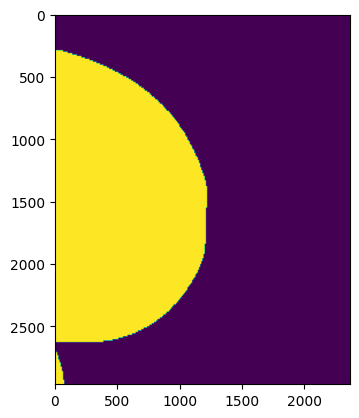

In [73]:
plt.imshow(Temp._temp_mock)